In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
import os
#created a .kaggle directory
os.makedirs('/root/.kaggle', exist_ok = True)

#moved kaggle_json into created directory
!cp kaggle.json /root/.kaggle/

#changed file permission
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# downloaded dataset from Kaggle using API

!kaggle datasets download -d rahulvyasm/medical-insurance-cost-prediction

Dataset URL: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction
License(s): MIT
  0% 0.00/31.6k [00:00<?, ?B/s]
100% 31.6k/31.6k [00:00<00:00, 42.5MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('medical-insurance-cost-prediction.zip', 'r') as zip_ref:
  zip_ref.extractall('medical-insurance-cost-prediction')

In [7]:
file = os.listdir( 'medical-insurance-cost-prediction')
print(file)

med_ins_df = pd.read_csv('medical-insurance-cost-prediction/medical_insurance.csv')





['medical_insurance.csv']


In [8]:
insurance_df = med_ins_df.copy()

insurance_df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Initial Descriptive Analysis**

In [9]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [10]:
insurance_df.shape

(2772, 7)

In [11]:
insurance_df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [12]:
null_values = insurance_df.isnull().sum()
print(null_values)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64



The data has no missing values, let's do some EDA to see some initial analysis we can get from the data


**Exploratory Data Analysis**

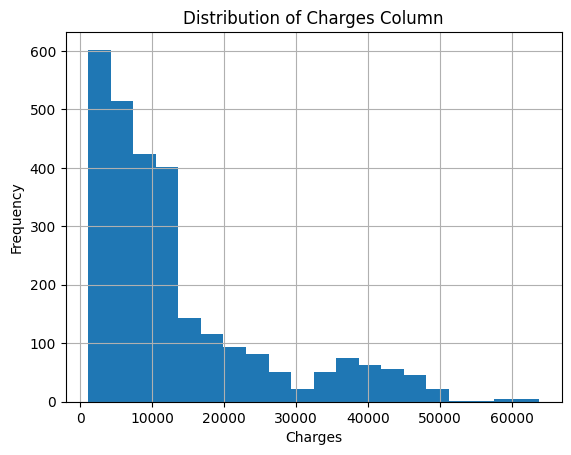

In [13]:


import matplotlib.pyplot as plt

insurance_df['charges'].hist(bins = 20)
plt.title('Distribution of Charges Column')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()



The Histogram shows that the charges column is right skewed with more of the values leaning towards the lower values. I will apply transformation to the column during model building.

Let's see what the log of the charges column will look like.

In [14]:
insurance_df['charges_log'] = np.log(insurance_df['charges'] + 1)


Let's see how the charges log column looks.

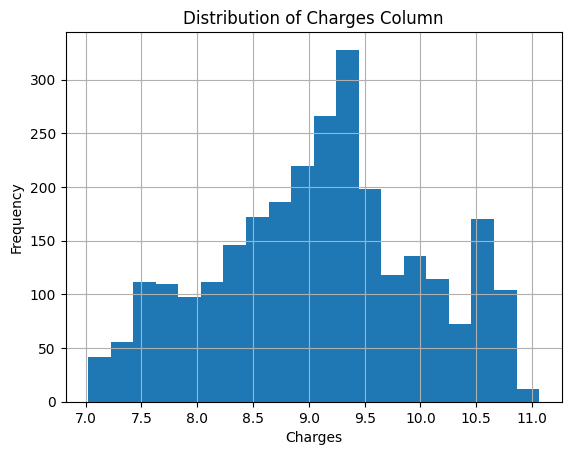

In [15]:
insurance_df['charges_log'].hist(bins = 20)
plt.title('Distribution of Charges Column')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

This looks more like a normal distribution and will be better for our model.

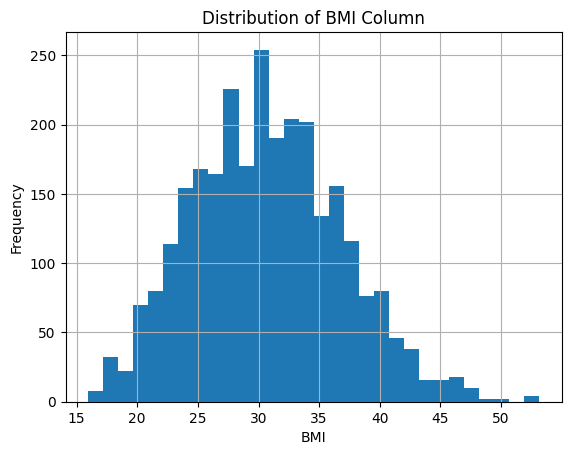

In [16]:
insurance_df['bmi'].hist(bins = 30)
plt.title('Distribution of BMI Column')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

The BMI column looks like a normal distribution so I would not transform it

Next let's see how the charges column is distributed among the genders

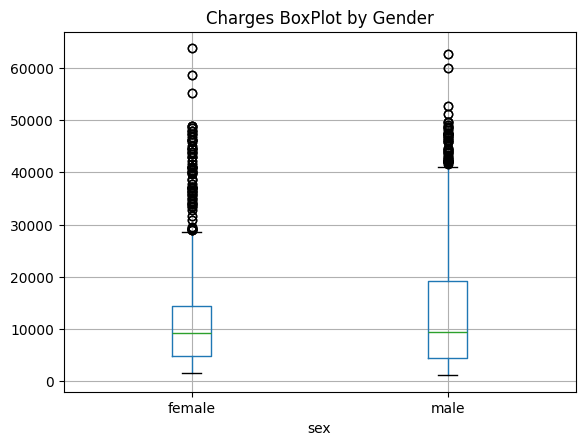

In [17]:
insurance_df.boxplot(column='charges', by = 'sex')
plt.title('Charges BoxPlot by Gender')
plt.suptitle('')
plt.show()




For the female gender, all charges fall below 50,000USD with an expection to 3 outliers.
For the male gender all charges fall below 52,000USD with an expection to 2 outliers.

Since there are outliers in both genders. I will like to explore this a little bit more to see the features associated with these outliers. We probably can learn from these.

In [18]:
med_filtered =insurance_df[insurance_df['charges'] >= 50000]
med_filtered

,age,sex,bmi,children,smoker,region,charges,charges_log
34,28,male,36.400,1,yes,southwest,51194.55914,10.843408
543,54,female,47.410,0,yes,southeast,63770.42801,11.063061
577,31,female,38.095,1,yes,northeast,58571.07448,10.978013
819,33,female,35.530,0,yes,northwest,55135.40209,10.917565
1146,60,male,32.800,0,yes,southwest,52590.82939,10.870316
1230,52,male,34.485,3,yes,northwest,60021.39897,11.002473
1300,45,male,30.360,0,yes,southeast,62592.87309,11.044423
1420,28,male,36.400,1,yes,southwest,51194.55914,10.843408
1929,54,female,47.410,0,yes,southeast,63770.42801,11.063061
1963,31,female,38.095,1,yes,northeast,58571.07448,10.978013


This is interesting to see. We can see that for everyone who's charges is above 50,000USD they are either smokers and they are obese.
i.e BMI is above 30

Correlation Heat Map

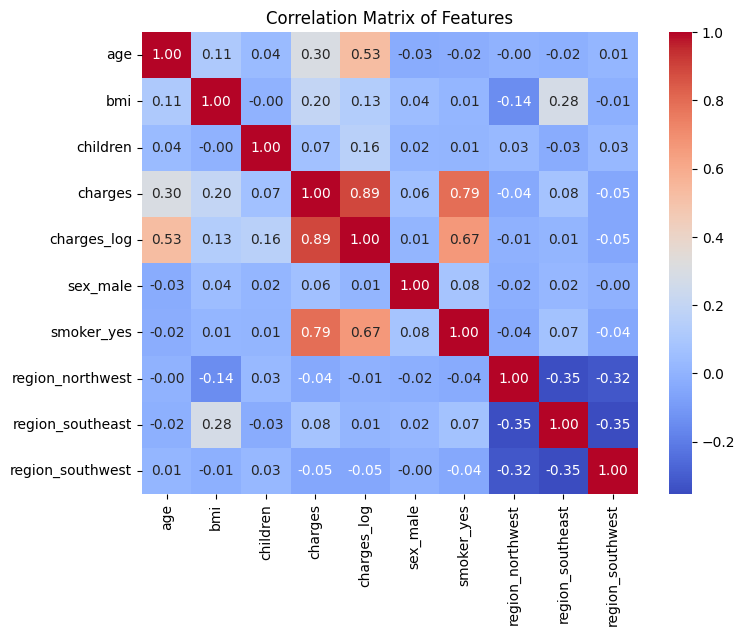

In [19]:
import seaborn as sns
insurance_df_encode = pd.get_dummies(insurance_df, drop_first=True)


plt.figure(figsize=(8, 6))
sns.heatmap(insurance_df_encode.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

Interestingly, there is a high positive correlation between the smoking status and insurance charges.





**Data Preprocessing**

I intend to try the Linear Regression Model and the Random Forest Model for this Prediction.

First I will try each of them with the charges_log column and then with the charges column as our target variable.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# I will be using the charges_log as the target variable for our model
X = insurance_df_encode.drop(['charges','charges_log'], axis=1)
y = insurance_df_encode['charges_log']

#numeric_features = ['age', 'bmi', 'children']
#numeric_transformer = StandardScaler()

#categorical_features = ['sex', 'smoker', 'region']
#categorical_transformer = OneHotEncoder(drop='first')

#preprocessor = ColumnTransformer(
    #transformers=[
       # ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    #])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)



Mean Absolute Error (MAE): 0.28620044786797116
Mean Squared Error (MSE): 0.2127715757971475
Root Mean Squared Error (RMSE): 0.46127169412088087
R-squared (R²): 0.7488009591888913


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


With a 75% r2 it shows that our model is able to explain 75% of the data points using the predictor variable. This is a fairly performing model, let's see if a Random forest model can do better.

In [23]:

coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})

# Sort by coefficient magnitude for better interpretability
coef_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)

print(coef_df)

            Feature  Coefficient
4        smoker_yes     1.573362
6  region_southeast    -0.180392
7  region_southwest    -0.133182
2          children     0.099769
5  region_northwest    -0.066211
3          sex_male    -0.061833
0               age     0.034946
1               bmi     0.012864


**Explanation of the co-efficients**

**smoker_yes:**

This coefficient (1.573362) is the highest among all features, indicating that being a smoker has a strong positive impact on charges. Since smoker_yes is a binary variable (1 for smokers, 0 for non-smokers), this means that smoking is associated with a significant increase in medical charges.

**region_southeast:**

The coefficient (-0.180392) suggests that being in the Southeast region slightly reduces medical charges compared to other regions.

**region_southwest:**

Similarly, this negative coefficient (-0.133182) implies that residing in the Southwest region is associated with a small decrease in charges relative to the omitted region.

**children:**

The positive coefficient (0.099769) for children indicates that as the number of children increases, medical charges tend to increase slightly. Each additional child corresponds to a small increase in charges.

**region_northwest:**

With a coefficient of -0.066211, residing in the Northwest region is associated with a slight decrease in charges compared to other regions

**sex_male:**

The coefficient (-0.061833) for sex_male indicates that being male has a slightly negative association with medical charges compared to female. This effect is quite small.

**age:**

The coefficient (0.034946) for age suggests that as age increases, medical charges increase modestly. For each additional year of age, charges are expected to increase slightly.

**bmi:**

The coefficient (0.012864) for bmi indicates a small positive association between body mass index and charges. As bmi increases by 1 unit, charges increase slightly.


**Summary**

The feature smoker_yes has the largest effect on medical charges, which is consistent with real-world expectations as smoking is associated with higher health risks and consequently higher medical costs.
Regional factors (southeast, southwest, northwest) have minor effects on charges.
Children, age, and bmi also have small positive relationships with charges, while sex has a small negative impact if the person is male.


I'm going to make a prediction with Random Forest model.

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.10352173246995336
Mean Squared Error (MSE): 0.06902006548992605
Root Mean Squared Error (RMSE): 0.26271670196225827
R-squared (R²): 0.9185146127586195


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The Random forest model has a 91% r2 which is a better model.

In [25]:
# Get feature importance and create a DataFrame
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importances)

            Feature  Importance
4        smoker_yes    0.447732
0               age    0.370972
1               bmi    0.107649
2          children    0.042045
3          sex_male    0.010716
6  region_southeast    0.007659
5  region_northwest    0.007341
7  region_southwest    0.005886


Now I am going to use the charges column instead of the charges_log column.

In this phase, I am going to train 2 models - Linear Regression and Random Forest. Using the StandardScaler and Hot encoding Transformations I will transform the numeric features and categorical features respectively.

In [26]:
# Scaling and Preprocessing

X = insurance_df.drop(['charges','charges_log'], axis=1)
y = insurance_df['charges']

numeric_features = ['age', 'bmi', 'children']
numeric_transformer = StandardScaler()

categorical_features = ['sex', 'smoker', 'region']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=180)

Linear Regression Performance:
MAE: 4171.056971960493
MSE: 36197781.919400044
R²: 0.7326878915090154
Random Forest Performance:
MAE: 1271.728738314219
MSE: 7624830.436542092
R²: 0.9436924200102457


<Figure size 1200x500 with 0 Axes>

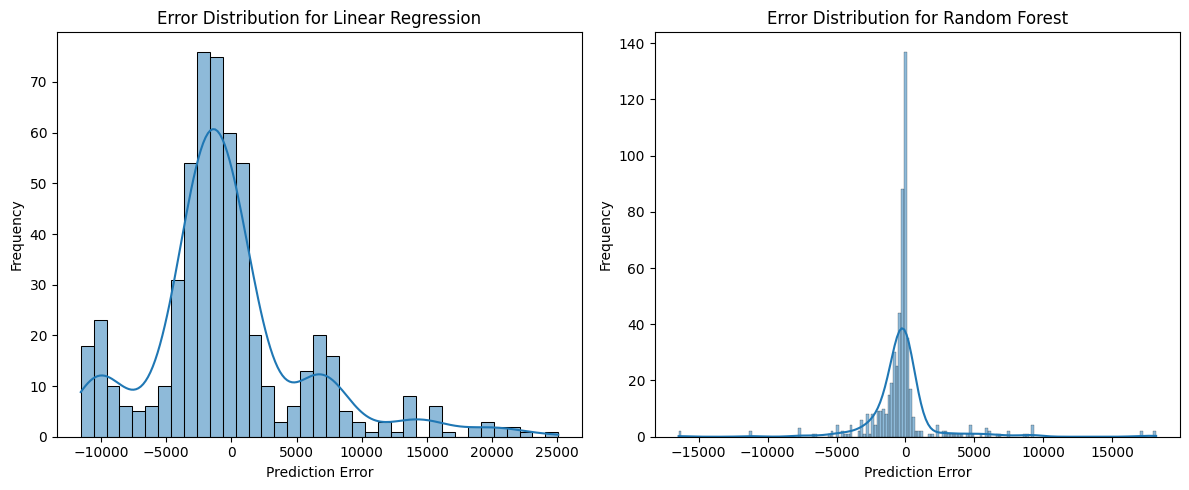

In [27]:
# Model building and training

models = {
'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=180)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Predictions": y_pred
    }

    print(f"{name} Performance:")
    print("MAE:", results[name]["MAE"])
    print("MSE:", results[name]["MSE"])
    print("R²:", results[name]["R2"])

    plt.figure(figsize=(12, 5))

for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, 2, i + 1)
    sns.histplot(y_test - res["Predictions"], kde=True)
    plt.title(f"Error Distribution for {name}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Explanation of Model Metrics and Diagram**

The Random forest model has a 94% accuracy against the Linear regression which has a 73% accuracy.

The Random Forest shows a more concentrated error distribution, meaning it makes predictions closer to the actual values most of the time. It has fewer large errors, indicating higher accuracy.
Linear Regression has a wider distribution of errors, with more instances of both positive and negative large errors, suggesting that it might struggle to accurately capture the data patterns.

This means that training the Random Forest Model to predict the charges features after applying standard scaling provided a better model overall.


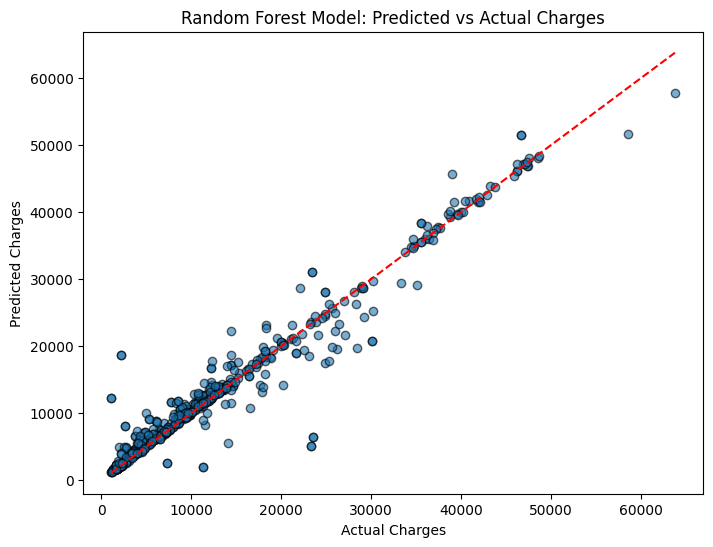

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, results["Random Forest"]["Predictions"], alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Random Forest Model: Predicted vs Actual Charges")
plt.show()

**Explanation of the Scatter plot**


Most points are close to the red dashed line, which indicates that the model's predictions are generally accurate. The closer the points are to this line, the better the model is performing.


The points are tightly clustered around the line, especially for lower charge values, indicating that the model is predicting low to medium charges well.


A few points lie further from the line, representing cases where the model's predictions differ significantly from the actual values. This may indicate outliers in the data or cases where the Random Forest model struggles to predict effectively.


In conclusion, the plot shows that the Random Forest model performs well for most data points, especially for lower and medium values of charges but there is some increased deviation in the predictions for higher charges.